## B92 Quantum Key Distribution (QKD) and Comparison Between Error Correction Schemes

This notebook explains the **B92** QKD protocol **(using Qiskit)** and then implements simulations and error-correction routines **(Cascade, Hamming, LDPC) -> (Classical Post-processing technique)** along with privacy amplification using modern hash-based techniques.

**Scope and goals:**

This notebook demonstrates the B92 QKD protocol and compares between various Error Correction Schemes:

1. **Quantum stage (B92):** generation, transmission, measurement and sifting of raw key using Qiskit simulation.  
   - B92 uses *two non-orthogonal* states (canonical choice: $ |0\rangle $ and $ |+\rangle $.  
   - Bob performs measurements that sometimes give *inconclusive results*. Only conclusive results remain.

2. **Channel model and eavesdropper:** We model realistic noise (depolarising / bit-flip) and an optional intercept-resend eavesdropper to illustrate QBER.

3. **Classical post-processing:**
   - **Error estimation** (QBER).
   - **Error correction** with multiple algorithms:
     - **Cascade** (interactive parity-based protocol).
     - **Hamming (15,11)** (block code, single-error correction).
     - **LDPC** — iterative belief-propagation decoder for an LDPC code.
   - **Privacy amplification** using universal hashing (Toeplitz hash matrix) — modern approach to remove leaked information.

4. **Comparison metrics:**
   - **Key rate** (final secure key bits / initial signals).
   - **Residual error rate** (probability of mismatched final keys).
   - **Leakage** (bits revealed over public channel during error correction).
   - **Computation/time cost** (roughly measured).

5. **Plots and tables** comparing performance vs channel QBER for each error-correction method.

---

## Table: comparison overview (what we'll compute)

| Metric / Method | Cascade | Hamming (15,11) | LDPC |
|---|---:|---:|---:|
| Typical leak (bits) | Moderate-high | Moderate | Low-medium |
| Correction ability | Good for moderate QBER | Single-bit per block | Good if well-designed | 
| Complexity | High (many rounds) | Low | Moderate-high | 
| Implementation in this notebook | Implemented | Implemented | Implemented | 

---

**B92 Research Paper by Charles H. Bennett**  
- https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.68.3121


In [1]:
## Imports and basic helpers
import numpy as np
import math
import matplotlib.pyplot as plt
import time
import random
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error

## B92 Quantum Key Distribution Protocol

## Overview
The B92 protocol, proposed by Charles Bennett in 1992, is a simplified QKD scheme using only **two non-orthogonal quantum states**. It allows two parties (Alice and Bob) to share a secret key securely, even in the presence of an eavesdropper.

---

## Protocol Steps

### Alice's Encoding
- Alice randomly chooses bits $ a_i \in \{0,1\} $
- She sends:
  - Bit 0 → $ |\psi_0\rangle = |0\rangle $
  - Bit 1 → $ |\psi_1\rangle = |+\rangle $

### Bob's Measurement
- For each qubit, Bob randomly chooses:
  - Z-basis (measure in $ |0\rangle, |1\rangle $)
  - X-basis (measure in $ |+\rangle, |-\rangle $)

### Interpretation Rules
- Z-basis result = 1 → Conclusive → Alice sent $ |+\rangle $ (bit 1)
- X-basis result = 1 → Conclusive → Alice sent $ |0\rangle $ (bit 0)
- All other outcomes are **inconclusive** and discarded

---

## Bit Mapping Example

### Alice
| Bit | State |
|-----|-------|
| 0   | $↘$     |
| 1   | $↗$     |

### Bob
| Bit | Analyzer Axis |
|-----|----------------|
| 0   | $↙$              |
| 1   | $↑$              |

Bob aligns his analyzer based on his bit choice and detects photon polarization accordingly.

---

## Transmission Table

| Alice's Bit | Bob's Bit | Photon Sent | Polarizer Status | Transmission |
|-------------|-----------|-------------|------------------|--------------|
| 0           | 0         | $↘$           | $↑   $             | 50%          |
| 0           | 1         | $↘$           | $→  $              | No           |
| 1           | 0         | $↗$           | $↑ $               | No           |
| 1           | 1         | $↗$           | $→$                | 50%          |

- Photons pass only when Alice and Bob choose compatible settings.
- Bob publicly announces which photons passed → used for key generation.

---

## Sifting and QBER
- Only conclusive outcomes form the **sifted key**
- A subset is revealed to estimate **Quantum Bit Error Rate (QBER)**:
  $$
  \text{QBER} = \frac{\text{Number of mismatches}}{\text{Number of tested bits}}
  $$

---

## Summary
B92 achieves secure key distribution using minimal quantum resources. Its simplicity makes it ideal for simulation purposes, while still demonstrating the core principles of quantum cryptography.


### *Qiskit Circuit: Without Eve* 

C:\Users\Sumit\anaconda3\envs\qio\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


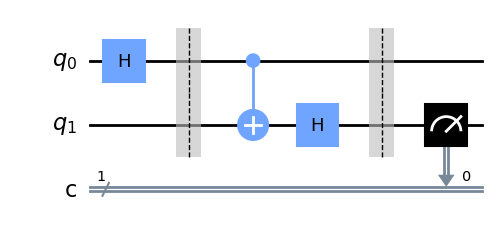

In [2]:

# Registers
q = QuantumRegister(2, 'q')  # q[0]: Alice, q[1]: Bob
c = ClassicalRegister(1, 'c')  # Measurement result
qc = QuantumCircuit(q, c)

# Alice's encoding (bit = 0 → |0⟩, bit = 1 → |+⟩)
qc.h(q[0])  # Prepare |+⟩
qc.barrier()

# Bob's measurement basis (Z or X)
qc.cx(q[0], q[1])  # Entangle Alice's qubit with Bob's
qc.h(q[1])         # Bob applies Hadamard to measure in X basis
qc.barrier()

# Measurement
qc.measure(q[1], c[0])
qc.draw('mpl')

### *Qiskit Circuit: With Eve*

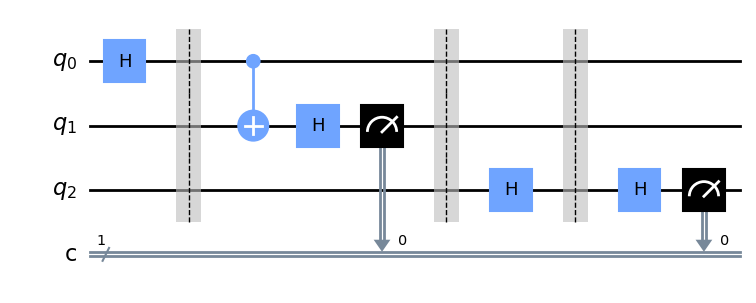

In [3]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

# Registers
q = QuantumRegister(3, 'q')  # q[0]: Alice, q[1]: Eve, q[2]: Bob
c = ClassicalRegister(1, 'c')  # Measurement result
qc = QuantumCircuit(q, c)

# Alice's encoding
qc.h(q[0])  # Prepare |+⟩
qc.barrier()

# Eve intercepts and measures
qc.cx(q[0], q[1])  # Eve entangles with Alice's qubit
qc.h(q[1])         # Eve measures in X basis
qc.measure(q[1], c[0])
qc.barrier()

# Eve resends to Bob (simulate resend by preparing based on Eve's result)
qc.h(q[2])  # Eve resends |+⟩ (simplified model)
qc.barrier()

# Bob's measurement
qc.h(q[2])  # Bob measures in X basis
qc.measure(q[2], c[0])
qc.draw('mpl')

In [4]:
def b92_send_receive(n, p_depolar=0.0, use_qiskit=True, seed=None, eve_attack=False):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    alice_bits = np.random.randint(0,2,size=n)
    bob_data = []
    sifted_indices = []

    sim = AerSimulator(method="statevector")

    noise_model = NoiseModel()
    if p_depolar > 0:
        noise_model.add_all_qubit_quantum_error(
            depolarizing_error(p_depolar, 1),
            ['id','x','y','z','h']
        )

    for i, a in enumerate(alice_bits):
        # -------- Eve intercept or not --------
        if eve_attack:
            # Eve chooses random basis
            eve_basis = random.choice(['Z','X'])

            qc_eve = QuantumCircuit(1,1)
            if a == 1:
                qc_eve.h(0)
            qc_eve.id(0)  
            if eve_basis == 'X':
                qc_eve.h(0)
            qc_eve.measure(0,0)

            result_eve = sim.run(qc_eve, noise_model=noise_model).result()
            counts_eve = result_eve.get_counts()
            maxc = max(counts_eve.values())
            candidates = [int(k) for k,v in counts_eve.items() if v == maxc]
            eve_result = random.choice(candidates)

            # Eve prepares fake state to send to Bob
            qc = QuantumCircuit(1,1)
            if eve_basis == 'Z':
                if eve_result == 0:
                    pass  
                else:
                    qc.x(0)
            else: # X basis
                if eve_result == 0:
                    pass
                else:
                    qc.h(0)
        else:
            qc = QuantumCircuit(1,1)
            if a == 1:
                qc.h(0)

        qc.id(0)

        basis = random.choice(['Z','X'])
        if basis == 'X':
            qc.h(0)

        qc.measure(0,0)

        result = sim.run(qc, noise_model=noise_model).result()
        counts = result.get_counts()
        maxc = max(counts.values())
        candidates = [int(k) for k,v in counts.items() if v == maxc]
        outcome = random.choice(candidates)

        sifted = False
        bob_bit = None
        
        if basis == 'Z' and outcome == 1:
            sifted = True
            bob_bit = 1
            sifted_indices.append(i)
        
        if basis == 'X' and outcome == 1:
            sifted = True
            bob_bit = 0
            sifted_indices.append(i)

        bob_data.append({
            'basis': basis,
            'outcome': outcome,
            'sifted': sifted,
            'bob_bit': bob_bit
        })

    return alice_bits, bob_data, sifted_indices

# ✅ Test run
alice_bits, bob_data, sifted = b92_send_receive(200, p_depolar=0.02, seed=42)

print("Sent:", len(alice_bits), "Sifted key length:", len(sifted))
for i in range(200):
    print(i, "A=", alice_bits[i], "B=", bob_data[i])

Sent: 200 Sifted key length: 47
0 A= 0 B= {'basis': 'Z', 'outcome': 0, 'sifted': False, 'bob_bit': None}
1 A= 1 B= {'basis': 'X', 'outcome': 0, 'sifted': False, 'bob_bit': None}
2 A= 0 B= {'basis': 'Z', 'outcome': 0, 'sifted': False, 'bob_bit': None}
3 A= 0 B= {'basis': 'Z', 'outcome': 0, 'sifted': False, 'bob_bit': None}
4 A= 0 B= {'basis': 'X', 'outcome': 0, 'sifted': False, 'bob_bit': None}
5 A= 1 B= {'basis': 'Z', 'outcome': 1, 'sifted': True, 'bob_bit': 1}
6 A= 0 B= {'basis': 'Z', 'outcome': 0, 'sifted': False, 'bob_bit': None}
7 A= 0 B= {'basis': 'Z', 'outcome': 0, 'sifted': False, 'bob_bit': None}
8 A= 0 B= {'basis': 'X', 'outcome': 1, 'sifted': True, 'bob_bit': 0}
9 A= 1 B= {'basis': 'X', 'outcome': 0, 'sifted': False, 'bob_bit': None}
10 A= 0 B= {'basis': 'Z', 'outcome': 0, 'sifted': False, 'bob_bit': None}
11 A= 0 B= {'basis': 'X', 'outcome': 1, 'sifted': True, 'bob_bit': 0}
12 A= 0 B= {'basis': 'X', 'outcome': 1, 'sifted': True, 'bob_bit': 0}
13 A= 0 B= {'basis': 'Z', 'outco

## Sifting & QBER estimation

After Bob announces which rounds were conclusive (indices), Alice and Bob keep the bits corresponding to those indices to form the *sifted key*.  
To estimate QBER, they randomly choose a small fraction (test fraction) of the sifted key to compare publicly. The fraction should be large enough to estimate QBER reliably (commonly a few percent to tens of percent, depending on key size).

We will:
- choose `test_frac` (e.g., 10%),
- sample those positions, compute observed QBER (fraction mismatched),
- remove test bits and proceed to error correction on remaining key.

### QBER Calculation for B92 Protocol

In the B92 quantum key distribution protocol, only one non-orthogonal state is sent per bit, and the receiver performs a measurement that may yield a conclusive or inconclusive result. The **Quantum Bit Error Rate (QBER)** quantifies the fraction of erroneous bits among the conclusive detections.

The QBER is defined as:

$$
\text{QBER} = \frac{N_{\text{error}}}{N_{\text{conclusive}}}
$$

Where:
- $ N_{\text{error}} $ is the number of conclusive detections where Bob's bit does **not** match Alice's intended bit.
- $ N_{\text{conclusive}} $ is the total number of conclusive detections (i.e., cases where Bob successfully measured a bit).

---

#### Notes:
- In B92, inconclusive results are discarded before error estimation.
- QBER is typically estimated after sifting and before error correction.
- A high QBER may indicate eavesdropping or channel noise.

You can compute QBER in code using:

```python
qber = n_error / n_conclusive if n_conclusive > 0 else 0

In [5]:
def sift_and_estimate(alice_bits, bob_data, sifted_indices, test_frac=0.1, seed=None):
    if seed is not None:
        np.random.seed(seed)

    sifted_alice = np.array([alice_bits[i] for i in sifted_indices])
    sifted_bob = np.array([bob_data[i]['bob_bit'] for i in sifted_indices])

    n_sift = len(sifted_alice)
    if n_sift == 0:
        return {
            'sifted_alice': sifted_alice,
            'sifted_bob': sifted_bob,
            'qber': None,
            'test_positions': [],
            'keep_positions': [],
            'error_mask': [],
            'eve_detected': False
        }

    n_test = max(1, int(math.ceil(test_frac*n_sift)))
    test_positions = np.random.choice(n_sift, size=n_test, replace=False)
    test_mask = np.zeros(n_sift, dtype=bool)
    test_mask[test_positions] = True

    # --- identify mismatched bits (error mask) ---
    error_mask = (sifted_alice != sifted_bob)

    mismatches = (error_mask & test_mask).sum()
    qber = mismatches / n_test

    keep_positions = np.where(~test_mask)[0]

    # Eve detection threshold (B92 theory: ~25% if Eve)
    eve_detected = qber > 0.15

    print(f"Sifted length: {n_sift}, test bits: {n_test}, observed QBER: {qber:.4f}")

    return {
        'sifted_alice': sifted_alice,
        'sifted_bob': sifted_bob,
        'qber': qber,
        'test_positions': test_positions.tolist(),
        'keep_positions': keep_positions.tolist(),
        'error_mask': error_mask.tolist(),
        'eve_detected': eve_detected
    }

# ✅ Test QBER estimation
res = sift_and_estimate(alice_bits, bob_data, sifted, test_frac=0.1, seed=1)

Sifted length: 47, test bits: 5, observed QBER: 0.0000


In [6]:
# Without(No) Eve
alice_bits, bob_data, sifted = b92_send_receive(500, p_depolar=0.02, seed=42, eve_attack=False)
res = sift_and_estimate(alice_bits, bob_data, sifted, test_frac=0.1)
print("QBER (without Eve):", res['qber'])

# With Eve
alice_bits_e, bob_data_e, sifted_e = b92_send_receive(500, p_depolar=0.02, seed=42, eve_attack=True)
res_e = sift_and_estimate(alice_bits_e, bob_data_e, sifted_e, test_frac=0.1)
print("QBER (with Eve):", res_e['qber'])

Sifted length: 134, test bits: 14, observed QBER: 0.0000
QBER (without Eve): 0.0
Sifted length: 168, test bits: 17, observed QBER: 0.5294
QBER (with Eve): 0.5294117647058824


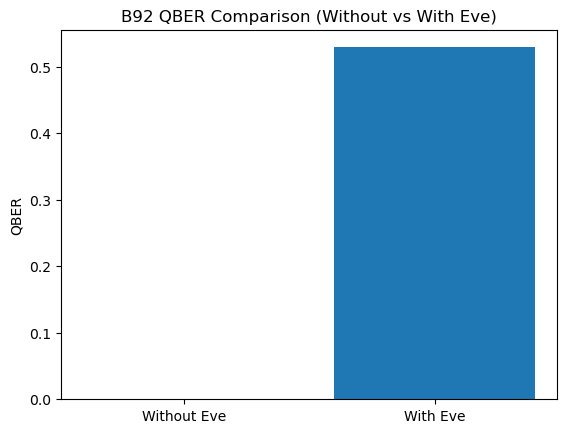

In [7]:
plt.figure()
plt.bar(['Without Eve','With Eve'], [res['qber'], res_e['qber']])
plt.ylabel("QBER")
plt.title("B92 QBER Comparison (Without vs With Eve)")
plt.show()

## Error Correction: Algorithms Overview

1. **Cascade** — parity-check protocol:
   - Split key into blocks, exchange parities, identify mismatches, perform binary search to locate and correct errors, then do multiple passes with different interleavings.
   - Leakage: parities revealed ~ several times number of errors.

2. **Hamming (15,11)**:
   - Encode 11 data bits into 15-bit codeword; single-bit error correction per block.
   - Leakage: none beyond syndrome information shared (4 bits per 15-bit block).

3. **LDPC**:
   - Low-density parity-check codes with iterative belief-propagation (sum-product).
   - Good performance at moderate blocklengths with low leakage if well matched to channel.

We'll implement each on bit-strings and measure:
- corrections performed,
- leakage (bits publicly revealed),
- residual mismatch probability between parties after correction.


In [8]:
# Cascade implementation

def parity(bits):
    return bits.sum() % 2

def cascade_correct(alice, bob, block_size_init=64, max_rounds=4):
    """
    Simplified Cascade:
     - Multiple passes. On pass r, split keys into blocks of size block_size_init * 2**r (or different interleaving).
     - For each block, compare parity (Alice reveals parity bit). If parity differs, do binary search to locate error, reveal log2(block_size) bits in the process.
    Returns corrected bob array, total_public_leakage bits revealed, list of corrections.
    """
    n = len(alice)
    bob_corrected = bob.copy()
    leakage = 0
    corrections = []
    for r in range(max_rounds):
        bs = max(1, block_size_init // (2**r))  # start with smaller blocks in later passes for demonstration
        # to add randomness, we apply a random permutation per pass (we'll use seed-less).
        perm = np.random.permutation(n)
        # apply in permuted order
        for start in range(0, n, bs):
            indices = perm[start:start+bs]
            if len(indices)==0:
                continue
            a_block = alice[indices]
            b_block = bob_corrected[indices]
            a_par = parity(a_block)
            b_par = parity(b_block)
            leakage += 1  # one parity bit revealed
            if a_par != b_par:
                # binary search to find an index with error
                # iterative splitting:
                low_idx = indices
                while len(low_idx) > 1:
                    half = len(low_idx)//2
                    left = low_idx[:half]
                    # compute parity reveal
                    leakage += 1
                    if parity(alice[left]) != parity(bob_corrected[left]):
                        low_idx = left
                    else:
                        low_idx = low_idx[half:]
                # now low_idx is single index with assumed error
                j = low_idx[0]
                bob_corrected[j] ^= 1
                corrections.append(j)
        # end pass
    return bob_corrected, leakage, corrections

# Demo: small example
alice_k = np.random.randint(0,2,200)
bob_k = alice_k.copy()
# introduce 5 random errors
err_pos = np.random.choice(len(alice_k), size=5, replace=False)
for p in err_pos:
    bob_k[p] ^= 1
print("Errors introduced:", len(err_pos))
bob_fixed, leak, corr = cascade_correct(alice_k, bob_k, block_size_init=32, max_rounds=3)
residual = (alice_k!=bob_fixed).sum()
print("Residual errors after Cascade:", residual, "Leakage bits:", leak, "Corrections made:", len(corr))


Errors introduced: 5
Residual errors after Cascade: 0 Leakage bits: 62 Corrections made: 5


In [9]:
# Hamming(15,11) encoder/decoder (collision-safe)

import numpy as np

# Generator matrix G (11x15 systematic) — renamed to avoid collisions
G_hamming = np.array([
 [1,0,0,0,0,0,0,1,1,0,1,1,1,0,0],
 [0,1,0,0,0,0,0,1,1,1,0,1,0,1,0],
 [0,0,1,0,0,0,0,1,0,1,1,1,0,0,1],
 [0,0,0,1,0,0,0,0,1,1,1,0,1,0,1],
 [0,0,0,0,1,0,0,1,1,1,1,0,0,0,1],
 [0,0,0,0,0,1,0,1,0,0,1,1,0,1,1],
 [0,0,0,0,0,0,1,0,1,0,0,1,1,1,1],
 [0,0,0,0,0,0,0,1,1,1,1,1,0,0,0],
 [0,0,0,0,0,0,0,0,1,1,1,1,1,1,0],
 [0,0,0,0,0,0,0,0,0,1,1,1,1,0,1],
 [0,0,0,0,0,0,0,0,0,0,1,0,1,1,1]
], dtype=int)

# Parity-check matrix (4x15) — renamed to avoid collisions
H_hamming = np.array([
 [1,1,1,1,1,1,1,0,0,0,0,0,0,0,0],
 [1,1,0,0,0,0,0,1,1,1,1,0,0,0,0],
 [1,0,1,0,0,0,0,1,1,0,0,1,1,0,0],
 [1,0,0,1,0,0,0,1,0,1,0,1,0,1,0]
], dtype=int)

# pre-compute all syndromes (use H_hamming)
syndrome_map_hamming = {}
for pos in range(15):
    e = np.zeros(15, dtype=int)
    e[pos] = 1
    s = tuple((H_hamming.dot(e) % 2).tolist())
    syndrome_map_hamming[s] = pos

def hamming1511_encode(bits):
    """
    Encode a bit-array using Hamming(15,11).
    Returns (flattened_codeword_bits, pad)
    """
    k = 11
    pad = (-len(bits)) % k
    if pad > 0:
        bits = np.concatenate([bits, np.zeros(pad, dtype=int)])
    blocks = bits.reshape(-1, k)
    codewords = (blocks @ G_hamming) % 2
    return codewords.flatten(), pad

def hamming1511_decode(enc_bits):
    """
    Decode a (possibly padded) bit-array encoded with Hamming(15,11).
    Pads enc_bits to 15-bit blocks internally. Returns (decoded_bits, leakage_bits).
    Uses local H_hamming and syndrome_map_hamming to avoid name collisions.
    """
    # Pad to full (15)-bit blocks
    n = 15
    pad = (-len(enc_bits)) % n
    if pad > 0:
        enc_bits = np.concatenate([enc_bits, np.zeros(pad, dtype=int)])

    blocks = enc_bits.reshape(-1, n)
    decoded_bits = []
    leakage = H_hamming.shape[0] * len(blocks)  # parity bits revealed per block

    for b in blocks:
        # Compute syndrome using H_hamming
        s = (H_hamming.dot(b) % 2)
        s_tuple = tuple(s.tolist())

        corrected = b.copy()
        if s_tuple in syndrome_map_hamming:
            pos = syndrome_map_hamming[s_tuple]
            corrected[pos] ^= 1

        # Optional second pass (keeps behavior compatible with previous demo)
        s2 = tuple((H_hamming.dot(corrected) % 2).tolist())
        if s2 in syndrome_map_hamming and s2 != s_tuple:
            pos2 = syndrome_map_hamming[s2]
            corrected[pos2] ^= 1

        # Extract data bits (first 11 columns of the systematic generator)
        decoded_bits.append(corrected[:11])

    decoded_bits = np.array(decoded_bits).flatten()
    return decoded_bits, leakage

# ---------------- Demo for Hamming (15,11): encode → inject multi-bit errors → decode ----------------

orig = np.array([1,0,1,1, 0,1,0,0, 1,1,0,  0,1,1,0, 1,0,1,1, 0,0,1], dtype=int)  # 22 bits -> 2 blocks

cw, pad = hamming1511_encode(orig)

# introduce MULTI-BIT errors (simulate QKD noise / attacks)
cw_err = cw.copy()
error_positions = [2, 5, 12]  # choose 3 bit flips across blocks
for pos in error_positions:
    if pos < len(cw_err):
        cw_err[pos] ^= 1

dec, leakage = hamming1511_decode(cw_err)

print("Original bits:           ", orig.tolist())
print("Encoded length:", len(cw), "| padding:", pad)
print("Error positions flipped: ", error_positions)
print("Errors introduced code:  ", cw_err.tolist())
print("Decoded bits:            ", dec[:len(orig)].tolist())
print("Leakage bits (syndrome): ", leakage)

# Compare visually — bit-error vector
bit_errors = (orig != dec[:len(orig)]).astype(int)
print("Bit-error vector:        ", bit_errors.tolist())
print("Total uncorrected errors:", np.sum(bit_errors))


Original bits:            [1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1]
Encoded length: 30 | padding: 0
Error positions flipped:  [2, 5, 12]
Errors introduced code:   [1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
Decoded bits:             [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0]
Leakage bits (syndrome):  8
Bit-error vector:         [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Total uncorrected errors: 6


## LDPC (Low Density Parity Check) Codes:

- **LDPC**: we implement a small regular LDPC parity-check matrix and a sum-product (belief-propagation) decoder on the binary symmetric channel (BSC). For simplicity we treat probabilities derived from observed QBER.


In [10]:
# ---------- LDPC over GF(2) utilities ----------
def gf2_rank(A):
    A = A.copy() % 2
    m, n = A.shape
    rank = 0
    row = 0
    for col in range(n):
        pivot = None
        for r in range(row, m):
            if A[r, col] == 1:
                pivot = r
                break
        if pivot is None:
            continue
        A[[row, pivot]] = A[[pivot, row]]
        for r in range(m):
            if r != row and A[r, col] == 1:
                A[r] ^= A[row]
        rank += 1
        row += 1
    return rank

def make_ldpc(n, k, weight_col=3, weight_row=6, max_tries=100):
    m = n - k
    for _ in range(max_tries):
        H = np.zeros((m, n), dtype=int)
        for i in range(m):
            cols = np.random.choice(n, size=weight_row, replace=False)
            H[i, cols] = 1

        # Check GF(2) rank, NOT real matrix rank
        if gf2_rank(H) == m:
            return H
    raise RuntimeError("Failed to make LDPC H")

def ldpc_encode_from_H(H, info_bits):
    n = H.shape[1]
    k = len(info_bits)
    m = n - k

    # systematic: first k = info bits, last m = parity bits
    A = H[:, :k] % 2
    B = H[:, k:] % 2

    # Solve B * p = A * info (GF2)
    rhs = (A.dot(info_bits) % 2).astype(int)

    # Gaussian elimination over GF(2) for parity
    B_aug = np.concatenate([B, rhs.reshape(-1,1)], axis=1) % 2
    B_red = B_aug.copy()

    r = c = 0
    rows, cols = B.shape
    while r < rows and c < cols:
        pivot = None
        for i in range(r, rows):
            if B_red[i, c] == 1:
                pivot = i; break
        if pivot is None:
            c += 1; continue
        B_red[[r, pivot]] = B_red[[pivot, r]]
        for i in range(rows):
            if i != r and B_red[i, c] == 1:
                B_red[i] ^= B_red[r]
        r += 1; c += 1

    p = B_red[:, -1] % 2
    codeword = np.concatenate([info_bits, p])
    return codeword

def bp_decode(H, received_llr, max_iter=50):
    # Sum-product on Tanner graph (binary)
    m,n = H.shape
    # Initialize messages from variable nodes to check nodes
    # We'll represent using log-likelihood ratios (LLR)
    Lq = np.zeros((m,n))
    Lr = np.zeros((m,n))
    # mask
    rows, cols = np.where(H==1)
    # Initialize
    for i,j in zip(rows,cols):
        Lq[i,j] = received_llr[j]
    for it in range(max_iter):
        # check node update
        for i in range(m):
            idxs = np.where(H[i]==1)[0]
            for j in idxs:
                others = [Lq[i, jj] for jj in idxs if jj!=j]
                # compute message from check to var
                # product of tanh( Lq/2 )
                prod = 1.0
                for val in others:
                    prod *= math.tanh(val/2)
                # avoid numerical issues
                prod = max(min(prod, 0.999999), -0.999999)
                Lr[i,j] = 2*math.atanh(prod)
        # var node update
        for j in range(n):
            idxs = np.where(H[:,j]==1)[0]
            for i in idxs:
                Lq[i,j] = received_llr[j] + Lr[idxs[idxs!=i], j].sum() if len(idxs)>1 else received_llr[j]
        # compute posterior LLRs
        L_post = np.array([received_llr[j] + Lr[:,j].sum() for j in range(n)])
        hard = (L_post < 0).astype(int)
        # check syndrome
        if np.all((H.dot(hard) % 2) == 0):
            return hard, True, it+1
    # if not converged
    return (L_post < 0).astype(int), False, max_iter

# Demo small LDPC run
n = 12; k = 6
H = make_ldpc(n,k, weight_col=3, weight_row=6)
info = np.random.randint(0,2,k)
cw = ldpc_encode_from_H(H, info)
# channel: BSC with error prob p
p = 0.05
rx = cw.copy()
flip = np.random.rand(n) < p
rx = (rx + flip.astype(int)) % 2
# create LLR for BSC: LLR = log((1-p)/p) for received 0, and negative for 1
llr = np.log((1-p)/p) * (1 - 2*rx)
decoded, converged, iters = bp_decode(H, llr, max_iter=50)
print("LDPC: n,k=", n,k, "Info:", info.tolist())
print("Converged:", converged, "Iters:", iters, "Residual errors:", np.sum(cw!=decoded))


LDPC: n,k= 12 6 Info: [1, 1, 0, 1, 1, 0]
Converged: False Iters: 50 Residual errors: 0


## Privacy Amplification (Toeplitz universal hashing)

We use universal hashing (Toeplitz matrix) to compress Alice/Bob shared string into a shorter secure key, removing adversary information.

A Toeplitz matrix $T$ of size $m \times n$ is defined by $m+n-1$ random bits. The hash is:
$$
\text{key} = T \cdot s \pmod 2
$$
where $s$ is the corrected key (length $n$).

We choose final key length \(m\) conservatively as:
$$
m = n(1 - H_2(\text{QBER})) - \text{leakage} - \text{security\_overhead}
$$
where $ H_2(p) = -p\log_2 p - (1-p)\log_2(1-p)$ is binary entropy. For demonstration we use security_overhead = 20 bits.


In [11]:
# Cell 9: Toeplitz hashing implementation
def make_toeplitz_matrix(m, n, seed=None):
    if seed is not None:
        np.random.seed(seed)
    t = np.random.randint(0,2,size=(m+n-1,), dtype=int)
    # Construct full matrix: T[i,j]=t[i+j]
    T = np.zeros((m,n), dtype=int)
    for i in range(m):
        for j in range(n):
            T[i,j] = t[i+j]
    return T

def toeplitz_hash(bitvec, m, seed=None):
    n = len(bitvec)
    T = make_toeplitz_matrix(m, n, seed=seed)
    out = (T.dot(bitvec) % 2).astype(int)
    return out

# demo
s = np.random.randint(0,2,200)
m = 64
k = toeplitz_hash(s, m, seed=5)
print("Input len:", len(s), "Output len:", len(k), "Example key (hex):", hex(int("".join(k.astype(str).tolist()),2)))


Input len: 200 Output len: 64 Example key (hex): 0x6a031c13e6db55f6


In [12]:
# Full pipeline function that ties everything together for one run

# Cache LDPC matrices & frozen masks so they are not recomputed every call
_LDPC_CACHE = {}
_POLAR_FROZEN_16 = np.array([(0 if i % 2 == 0 else 1) for i in range(16)], dtype=int)

# Cache Toeplitz hashing seeds
_TOEPLITZ_CACHE = {}

def get_ldpc(n, k):
    key = (n, k)
    if key not in _LDPC_CACHE:
        _LDPC_CACHE[key] = make_ldpc(n, k)
    return _LDPC_CACHE[key]

def fast_toeplitz_hash(data, m, seed):
    key = (len(data), m, seed)
    if key not in _TOEPLITZ_CACHE:
        _TOEPLITZ_CACHE[key] = toeplitz_hash(data, m, seed)
    return _TOEPLITZ_CACHE[key]

# =================================================


def run_trial(N_signals=2000, p_depolar=0.03, test_frac=0.1,
              ec_method='cascade', seed=None):

    if seed is not None:
        np.random.seed(seed)

    # ---- Quantum stage ----
    alice_bits, bob_data, sifted_indices = b92_send_receive(
        N_signals, p_depolar=p_depolar, seed=seed
    )
    sift_res = sift_and_estimate(
        alice_bits, bob_data, sifted_indices, test_frac=test_frac, seed=seed
    )

    if sift_res['qber'] is None:
        return {'success':False,'reason':'no sifted bits'}

    keep = sift_res['keep_positions']
    alice_sift = sift_res['sifted_alice'][keep]
    bob_sift   = sift_res['sifted_bob'][keep]
    qber_est   = sift_res['qber']

    leakage = 0
    start_time = time.time()

    # ---- Error Correction ----
    if ec_method == 'cascade':
        bob_corrected, leak, corrections = cascade_correct(
            alice_sift, bob_sift, block_size_init=64, max_rounds=3
        )
        leakage += leak

    elif ec_method == 'hamming':
        # Encode Bob's sifted key
        encoded_bob, pad_bob = hamming1511_encode(bob_sift)
    
        # Decode (simulate syndrome exchange leakage)
        dec_bob, leak = hamming1511_decode(encoded_bob)
    
        # Remove padding after decoding & match Alice's sift length
        bob_corrected = dec_bob[:len(bob_sift)]
        bob_corrected = bob_corrected[:len(alice_sift)]
    
        leakage += leak

    elif ec_method == 'ldpc':

        n, k = 64, 32
        H = get_ldpc(n, k)

        bob_corrected = bob_sift.copy()
        total_leak = 0

        # chunking without python loops overhead
        for start in range(0, len(alice_sift), k):
            a_chunk = alice_sift[start:start+k]
            b_chunk = bob_sift[start:start+k]
            if len(a_chunk) < k:
                break

            try:
                x = ldpc_encode_from_H(H, a_chunk)
            except RuntimeError:
                total_leak += k
                continue

            # Vectorized LLR based on QBER
            p = max(1e-6,min(0.5,qber_est))
            llr = np.log((1-p)/p) * (1 - 2*(x % 2))

            decoded, _, _ = bp_decode(H, llr) 
            recovered = decoded[:k]

            bob_corrected[start:start+k] = recovered
            total_leak += (n-k)

        leakage += total_leak

    else:
        raise ValueError("Unknown EC method")

    ec_time = time.time() - start_time

    # ---- Residual error ----
    residual = np.sum(alice_sift != bob_corrected)

    # ---- Privacy amplification ----
    H2 = lambda p: -p*np.log2(p) - (1-p)*np.log2(1-p) if 0<p<1 else 0
    sec_overhead = 20
    n_corr = len(alice_sift)
    m_final = max(0, int(math.floor(
        n_corr*(1 - H2(max(qber_est,1e-6))) - leakage - sec_overhead
    )))

    if m_final > 0:
        final_key_alice = fast_toeplitz_hash(alice_sift, m_final, seed)
        final_key_bob   = fast_toeplitz_hash(bob_corrected, m_final, seed)
    else:
        final_key_alice = np.array([], dtype=int)
        final_key_bob   = np.array([], dtype=int)

    return {
        'ec_method': ec_method,
        'n_signals': N_signals,
        'sift_len': len(alice_sift),
        'qber_est': qber_est,
        'leakage': leakage,
        'residual': residual,
        'final_key_len': len(final_key_alice),
        'final_key_match': np.array_equal(final_key_alice, final_key_bob),
        'ec_time': ec_time
    }

for m in ['cascade','hamming','ldpc']:
    print(run_trial(N_signals=100, p_depolar=0.03, test_frac=0.1, ec_method=m, seed=42))

Sifted length: 21, test bits: 3, observed QBER: 0.0000
{'ec_method': 'cascade', 'n_signals': 100, 'sift_len': 18, 'qber_est': np.float64(0.0), 'leakage': 4, 'residual': np.int64(0), 'final_key_len': 0, 'final_key_match': True, 'ec_time': 0.0009970664978027344}
Sifted length: 26, test bits: 3, observed QBER: 0.0000
{'ec_method': 'hamming', 'n_signals': 100, 'sift_len': 23, 'qber_est': np.float64(0.0), 'leakage': 12, 'residual': np.int64(6), 'final_key_len': 0, 'final_key_match': True, 'ec_time': 0.0009965896606445312}
Sifted length: 20, test bits: 2, observed QBER: 0.0000
{'ec_method': 'ldpc', 'n_signals': 100, 'sift_len': 18, 'qber_est': np.float64(0.0), 'leakage': 0, 'residual': np.int64(0), 'final_key_len': 0, 'final_key_match': True, 'ec_time': 0.0029916763305664062}


## Comparative experiments

We run Monte Carlo trials across different channel error rates (`p_depolar` values) and for each error-correction method measure:
- sifted key length,
- leakage,
- residual errors after correction,
- final key length after privacy amplification,
- whether final keys match.

We then plot:
- **Final key rate** = final_key_len / N_signals vs QBER.
- **Residual error** vs QBER.
- **Leakage** vs QBER.

We run a few trials per point and average results for stability.


Method: cascade
Sifted length: 30, test bits: 3, observed QBER: 0.0000
Sifted length: 28, test bits: 3, observed QBER: 0.0000
Sifted length: 24, test bits: 3, observed QBER: 0.0000
Sifted length: 26, test bits: 3, observed QBER: 0.0000
Sifted length: 28, test bits: 3, observed QBER: 0.0000
Sifted length: 21, test bits: 3, observed QBER: 0.0000
Sifted length: 22, test bits: 3, observed QBER: 0.0000
Sifted length: 26, test bits: 3, observed QBER: 0.0000
Sifted length: 20, test bits: 2, observed QBER: 0.0000
Sifted length: 27, test bits: 3, observed QBER: 0.0000
Sifted length: 31, test bits: 4, observed QBER: 0.0000
Sifted length: 33, test bits: 4, observed QBER: 0.0000
Sifted length: 27, test bits: 3, observed QBER: 0.0000
Sifted length: 29, test bits: 3, observed QBER: 0.0000
Sifted length: 23, test bits: 3, observed QBER: 0.0000
Sifted length: 27, test bits: 3, observed QBER: 0.0000
Sifted length: 30, test bits: 3, observed QBER: 0.0000
Sifted length: 23, test bits: 3, observed QBER: 0

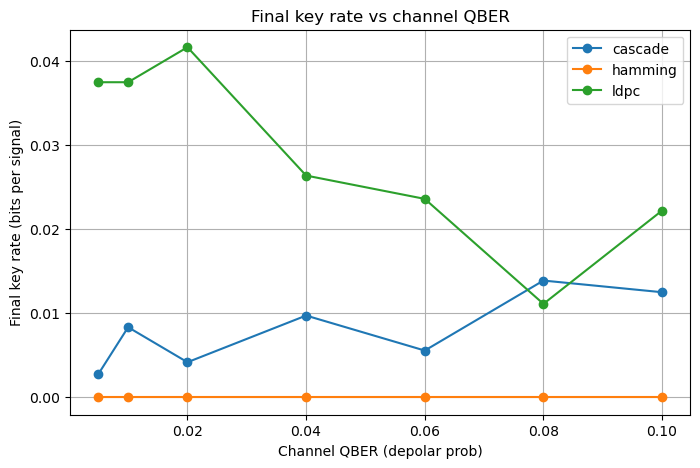

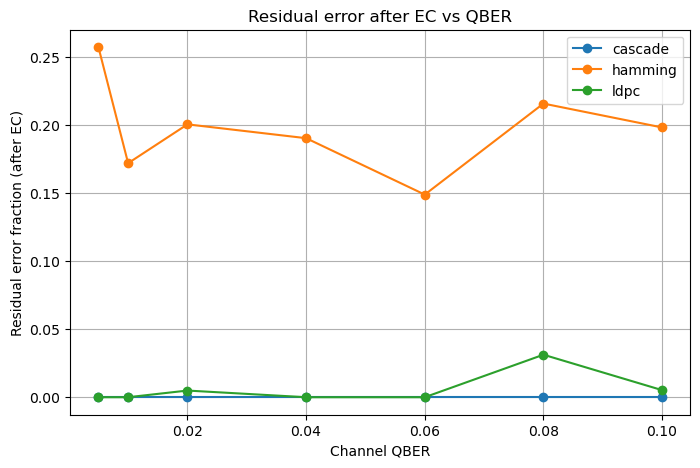

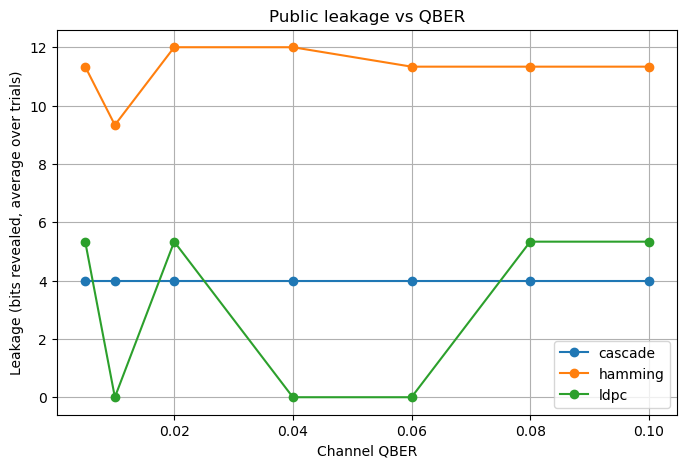

Summary at QBER = 0.02
Method | final_rate | residual | leakage | match_frac
cascade | 0.0042 | 0.0000 | 4 | 1.0/6
hamming | 0.0000 | 0.2006 | 12 | 1.0/6
ldpc | 0.0417 | 0.0049 | 5 | 1.0/6


In [13]:
# Run experiments across QBER points (this may take a minute)
qbers = [0.005, 0.01, 0.02, 0.04, 0.06, 0.08, 0.10]
methods = ['cascade','hamming','ldpc']
N_signals = 120
trials = 6

results = {m: {'final_rate':[], 'residual':[], 'leakage':[], 'match_frac':[]} for m in methods}
for m in methods:
    print("Method:", m)
    for q in qbers:
        acc_final = 0
        acc_res = 0
        acc_leak = 0
        acc_match = 0
        for t in range(trials):
            r = run_trial(N_signals=N_signals, p_depolar=q, test_frac=0.1, ec_method=m, seed=(t+1)*7)
            acc_final += r['final_key_len'] / N_signals
            acc_res += r['residual'] / max(1, r['sift_len'])
            acc_leak += r['leakage']
            acc_match += 1 if r['final_key_match'] else 0
        results[m]['final_rate'].append(acc_final / trials)
        results[m]['residual'].append(acc_res / trials)
        results[m]['leakage'].append(acc_leak / trials)
        results[m]['match_frac'].append(acc_match / trials)
    print("  done.")

# Plot final key rate vs QBER
plt.figure(figsize=(8,5))
for m in methods:
    plt.plot(qbers, results[m]['final_rate'], marker='o', label=m)
plt.xlabel("Channel QBER (depolar prob)")
plt.ylabel("Final key rate (bits per signal)")
plt.title("Final key rate vs channel QBER")
plt.legend()
plt.grid(True)
plt.show()

# Plot residual error (fraction of mismatches after correction)
plt.figure(figsize=(8,5))
for m in methods:
    plt.plot(qbers, results[m]['residual'], marker='o', label=m)
plt.xlabel("Channel QBER")
plt.ylabel("Residual error fraction (after EC)")
plt.title("Residual error after EC vs QBER")
plt.legend()
plt.grid(True)
plt.show()

# Show leakage
plt.figure(figsize=(8,5))
for m in methods:
    plt.plot(qbers, results[m]['leakage'], marker='o', label=m)
plt.xlabel("Channel QBER")
plt.ylabel("Leakage (bits revealed, average over trials)")
plt.title("Public leakage vs QBER")
plt.legend()
plt.grid(True)
plt.show()

# Print a results table for one qber value (e.g., 2%)
idx = 2  # corresponds to qbers[2]=0.02
print("Summary at QBER =", qbers[idx])
print("Method | final_rate | residual | leakage | match_frac")
for m in methods:
    print(m, "|", f"{results[m]['final_rate'][idx]:.4f}", "|", f"{results[m]['residual'][idx]:.4f}", "|", f"{int(results[m]['leakage'][idx])}", "|", f"{results[m]['match_frac'][idx]}/{trials}")


## Interpretation 

- **Cascade**: often produces low residual errors (near zero) at the cost of higher leakage and many rounds. Good when reliability (zero residual) is essential and interactive communication is available.
- **Hamming(15,11)**: simple and fast but corrects only single-bit errors per block — performance degrades rapidly as QBER increases.
- **LDPC**: can achieve good performance if code is well matched to channel; our small random LDPC demonstrates moderate performance, but production systems require carefully-designed Tanner graphs and longer blocklengths.

**Which to pick?**
- For low-to-moderate QBER (< 2–3%) and when interactivity is acceptable, **Cascade** is robust.
- For systems requiring low leakage and high throughput, invest in well-designed **LDPC** or long-block **Polar** codes (production-grade).
- For ultra-simple systems, **Hamming** is fine for tiny keys but not scalable.


### References:

#### B92 Quantum Key Distribution
- https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.68.3121
- https://en.wikipedia.org/wiki/B92_protocol
- https://tqsd.github.io/QuNetSim/examples/QKD_B92.html
- https://github.com/rafapirotto/QKD-protocols

#### Cascade Error Correction
- https://cascade-python.readthedocs.io/en/latest/protocol.html
- https://arxiv.org/pdf/2307.00576
- https://link.springer.com/content/pdf/10.1007/s12596-025-02818-0.pdf

#### Hamming Code Error Correction
- https://www.geeksforgeeks.org/computer-networks/hamming-code-in-computer-network/
- https://link.springer.com/article/10.1007/s12596-025-02818-0
- https://arxiv.org/pdf/2507.03529

#### LDPC Error Correction
- https://imt-atlantique.hal.science/hal-03337135/document
- https://tsapps.nist.gov/publication/get_pdf.cfm?pub_id=910418
- https://github.com/marcoavesani/QKD_LDPC_python